# Предсказание данных **MNIST**

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
import struct
from array import array

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
    
from autoencoders.autoencoder import Autoencoder
from models.pl_model import NeuralNetworkPL
from datasets.dataset import CustomDataset

### Подготовка данных

In [4]:
class MnistDataloader:
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_path, labels_path):
        with open(labels_path, 'rb') as label_file:
            magic, size = struct.unpack(">II", label_file.read(8))
            if magic != 2049:
                raise ValueError(f'Magic number mismatch in labels. Got {magic}, expected 2049')
            labels = array("B", label_file.read())

        with open(images_path, 'rb') as image_file:
            magic, size, rows, cols = struct.unpack(">IIII", image_file.read(16))
            if magic != 2051:
                raise ValueError(f'Magic number mismatch in images. Got {magic}, expected 2051')
            image_data = array("B", image_file.read())

        images = []
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols]).reshape(rows, cols)
            images.append(img)
            
        return np.array(images), np.array(labels)

    def load_data(self):
        (X_train, y_train), (X_test, y_test) = self.read_images_labels(
            self.training_images_filepath, self.training_labels_filepath
        ), self.read_images_labels(
            self.test_images_filepath, self.test_labels_filepath
        )
        
        X_train = np.array([np.ravel(x) for x in X_train], dtype=np.float32) / 255.0
        X_test = np.array([np.ravel(x) for x in X_test], dtype=np.float32) / 255.0

        return (X_train, y_train), (X_test, y_test)


mnist_dataloader = MnistDataloader(
    training_images_filepath='../data/mnist-dataset/train-images.idx3-ubyte',
    training_labels_filepath='../data/mnist-dataset/train-labels.idx1-ubyte',
    test_images_filepath='../data/mnist-dataset/t10k-images.idx3-ubyte',
    test_labels_filepath='../data/mnist-dataset/t10k-labels.idx1-ubyte'
)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

### Обучение автокодировщика

In [5]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

input_size = X_train.shape[1]  

autoencoder = Autoencoder(input_dim=input_size, latent_dim=128)
early_stop = EarlyStopping(monitor="val_loss", patience=10)
checkpoint = ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto",
    callbacks=[early_stop, checkpoint],
    log_every_n_steps=10
)
trainer.fit(autoencoder, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 567 K  | train
1 | decoder | Sequential | 568 K  | train
2 | loss_fn | BCELoss    | 0      | train
-----------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.544     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Epoch 199: 100%|██████████| 750/750 [00:10<00:00, 70.28it/s, v_num=46, val_loss=0.0657, train_loss=0.066] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 750/750 [00:10<00:00, 70.25it/s, v_num=46, val_loss=0.0657, train_loss=0.066]


### Визуализируем исходные и восстановленные изображения

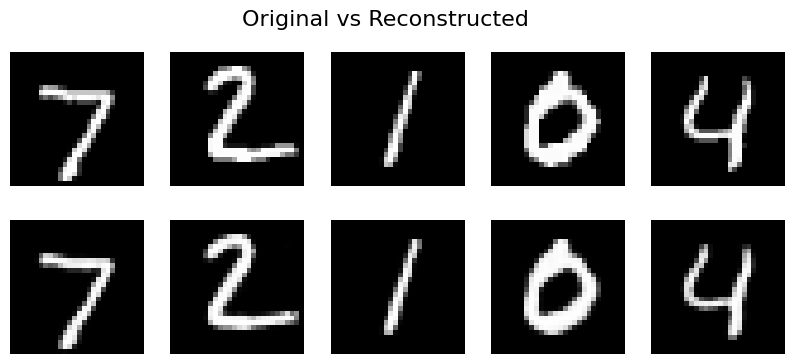

In [6]:
def plot_reconstructions(model, data_loader, num_images=5):
    model.eval()
    with torch.no_grad():
        for x_batch, _ in data_loader:
            x_batch = x_batch[:num_images]
            x_recon = model(x_batch)
            break

    fig, axes = plt.subplots(2, num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[0, i].imshow(x_batch[i].reshape(28, 28), cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(x_recon[i].reshape(28, 28), cmap='gray')
        axes[1, i].axis('off')

    plt.suptitle("Original vs Reconstructed", fontsize=16)
    plt.show()

plot_reconstructions(autoencoder, test_loader)

### Выводим оценку точности предсказаний

In [7]:
from sklearn.metrics import mean_squared_error

autoencoder.eval()
all_originals = []
all_recons = []

with torch.no_grad():
    for x_batch, _ in test_loader:
        x_flat = x_batch.view(x_batch.shape[0], -1)
        recons = autoencoder(x_flat)
        all_originals.append(x_flat.numpy())
        all_recons.append(recons.numpy())

all_originals = np.concatenate(all_originals)
all_recons = np.concatenate(all_recons)

mse = mean_squared_error(all_originals, all_recons)
print(f"Reconstruction MSE on test set: {mse:.6f}")

Reconstruction MSE on test set: 0.001675


### Получение латентных представлений

In [68]:
def extract_latent_representations(model, data_loader):
    model.eval()
    latents, labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.view(x_batch.size(0), -1)
            z = model.get_latent(x_batch)
            latents.append(z.numpy())
            labels.append(y_batch.numpy())

    return np.concatenate(latents), np.concatenate(labels)

X_train_latent, y_train_latent_labels = extract_latent_representations(autoencoder, train_loader)
X_val_latent, y_val_latent_labels = extract_latent_representations(autoencoder, val_loader)
X_test_latent, y_test_latent_labels = extract_latent_representations(autoencoder, test_loader)

train_latent_dataset = CustomDataset(X_train_latent, y_train_latent_labels)
val_latent_dataset = CustomDataset(X_val_latent, y_val_latent_labels)
test_latent_dataset = CustomDataset(X_test_latent, y_test_latent_labels)

train_latent_loader = DataLoader(train_latent_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_latent_loader = DataLoader(val_latent_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_latent_loader = DataLoader(test_latent_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)

### Обучение модели

In [70]:
latent_dim = X_train_latent.shape[1] 
output_size = len(np.unique(y_train_latent_labels))

model = NeuralNetworkPL(
    input_size=latent_dim,
    hidden_sizes=[100, 200],
    output_size=output_size,
    activation='relu',
    task='classification'
)

trainer = pl.Trainer(max_epochs=50, accelerator="auto", log_every_n_steps=10)
trainer.fit(model, train_latent_loader, val_latent_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | net  | Sequential | 35.1 K | train
--------------------------------------------
35.1 K    Trainable params
0         Non-trainable params
35.1 K    Total params
0.140     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 750/750 [00:04<00:00, 154.87it/s, v_num=49]      

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 750/750 [00:04<00:00, 154.68it/s, v_num=49]


### Тестирование

In [71]:
trainer.test(model, dataloaders=test_latent_loader)
    
def predict(model, data_loader):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for X_batch, _ in data_loader:
            logits = model(X_batch)
            probs = torch.softmax(logits, dim=1)
            all_preds.append(probs.numpy())
    return np.concatenate(all_preds)

y_pred_probs = predict(model, test_latent_loader)

Testing DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 294.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3255842626094818     │
└───────────────────────────┴───────────────────────────┘

### Визуализация

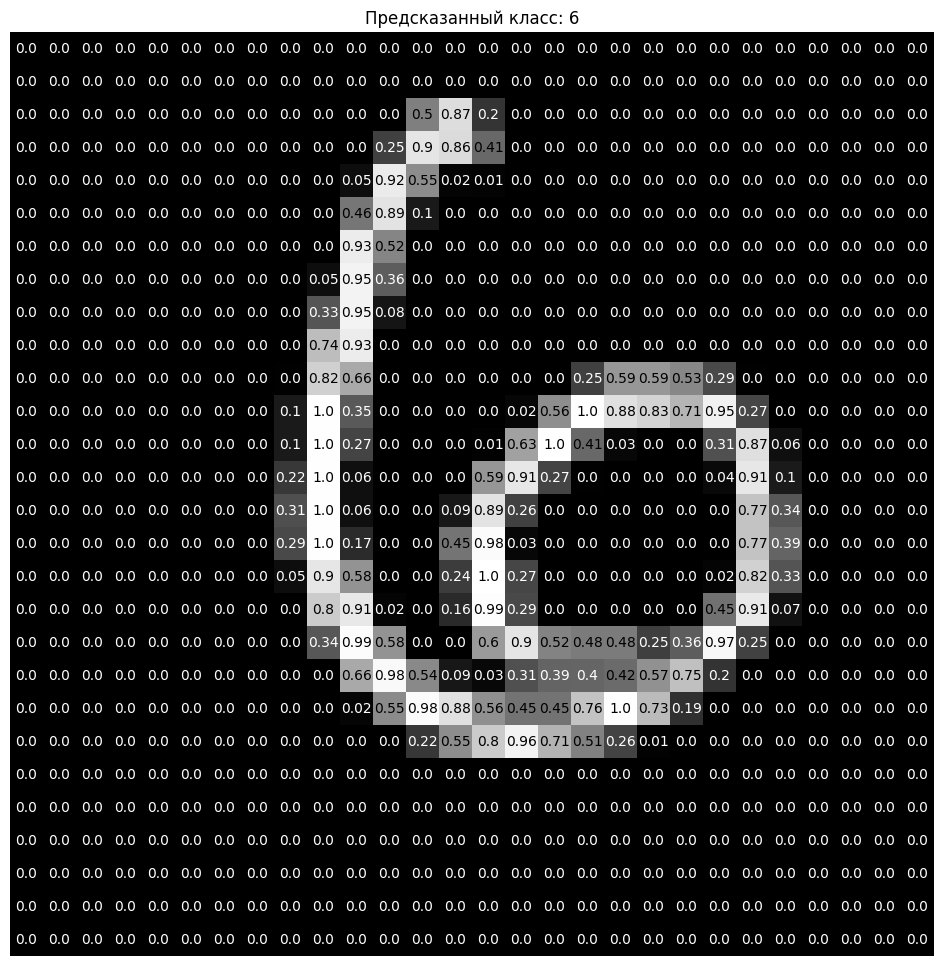

In [72]:
def visualize_input(img, ax):
    img_reshaped = img.reshape(28, 28)
    ax.imshow(img_reshaped, cmap='gray')
    width, height = img_reshaped.shape
    thresh = img_reshaped.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img_reshaped[x][y], 2)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img_reshaped[x][y] < thresh else 'black')

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
visualize_input(X_test[100], ax)
plt.title(f"Предсказанный класс: {np.argmax(y_pred_probs[100])}")
plt.axis('off')
plt.show()

### Сдвиг к другому классу

In [73]:
class_means = {}
for label in np.unique(y_train_latent_labels):
    mask = (y_train_latent_labels == label)
    class_means[label] = np.mean(X_train_latent[mask], axis=0)

index = 200 
original_image = X_test[index]
original_label = y_test_latent_labels[index]

print(f"Оригинальный класс: {original_label}")

x_tensor = torch.tensor(original_image, dtype=torch.float32).unsqueeze(0) 
z = autoencoder.get_latent(x_tensor).detach().numpy()

target_class = 8  
delta_z = class_means[target_class] - class_means[original_label]  
z_shifted = z + 0.5 * delta_z 

z_shifted_tensor = torch.tensor(z_shifted, dtype=torch.float32)
logits = model(z_shifted_tensor)
probs = torch.softmax(logits, dim=1).detach().numpy()

predicted_class = np.argmax(probs)

print(f"Предсказанный класс после сдвига: {predicted_class}")
print(f"Вероятности: {probs[0]}")

Оригинальный класс: 3
Предсказанный класс после сдвига: 3
Вероятности: [1.9874173e-05 4.9124751e-06 4.1315166e-04 9.8232275e-01 2.4016534e-05
 5.1877052e-03 4.6109030e-11 1.2087673e-03 6.2923920e-03 4.5264112e-03]


### Визуализация сдвинутой модели

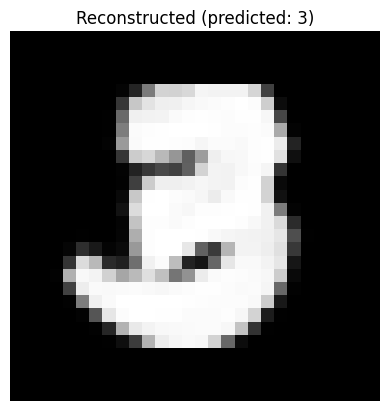

[[5.44949970e-08 4.02021811e-08 4.67117296e-08 5.26741957e-08
  5.73209000e-08 4.99142274e-08 5.43060565e-08 5.55397328e-08
  5.41057865e-08 4.99848234e-08 4.92616259e-08 4.73982169e-08
  1.21517296e-09 2.20578712e-11 7.05263764e-11 3.83774168e-09
  4.66620413e-08 5.61998803e-08 4.35957936e-08 4.94577357e-08
  4.58870275e-08 4.65257983e-08 4.01089686e-08 4.93273511e-08
  5.51524160e-08 4.32954863e-08 5.15113534e-08 4.60508112e-08
  4.45327011e-08 5.61773774e-08 4.42802950e-08 4.56740565e-08
  1.55178015e-09 2.02949445e-11 8.62656835e-10 9.12844522e-11
  1.69076385e-12 3.62705074e-11 1.42306895e-11 9.61535851e-10
  8.34282599e-09 6.65817609e-11 3.90002725e-10 9.96976390e-11
  5.76754790e-11 4.34242142e-10 3.45892692e-09 7.91943933e-08
  8.39768166e-09 2.11636247e-11 1.59778232e-11 4.30437977e-11
  5.26261950e-08 4.62889318e-08 4.90277614e-08 5.28847011e-08
  4.95573538e-08 4.88762169e-08 5.10596188e-08 2.81285856e-10
  3.85573344e-12 7.21311733e-10 2.77617079e-11 1.21764491e-11
  2.2092

In [ ]:
x_reconstructed = autoencoder.decoder(z_shifted_tensor).detach().numpy()
x_reconstructed = np.clip(x_reconstructed, 0, 1)

plt.imshow(x_reconstructed.reshape(28, 28), cmap='gray')
plt.title(f"Reconstructed (predicted: {predicted_class})")
plt.axis('off')
plt.show()